In [22]:
# DEPENDENCIES

import pysam
import pandas as pd
import HTSeq
import GeneImage
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm, trange
from tqdm import tqdm as tqdm
import cProfile
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

# GLOBAL VARS

FC30_DMGOTH_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC30.against_dmgoth.bam"
FC30_DMGOTH_MAX_AS_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC30.against_dmgoth.filtered_max_AS.bam"
FC30_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE ="/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC30.against_dmgoth.filtered_max_AS.primary_only.bam"

FC29_DMGOTH_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC29.against_dmgoth.bam"
FC29_DMGOTH_MAX_AS_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC29.against_dmgoth.filtered_max_AS.bam"
FC29_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE ="/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC29.against_dmgoth.filtered_max_AS.primary_only.bam"

FC30_DMGOTH_SUBSET_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC30.subset.against_dmgoth.bam"
FC30_DMGOTH_SUBSET_MAX_AS_BAMFILE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/bam/FC30.subset.against_dmgoth.filtered.bam"

REPEATMASKER_TE_ANNOTATIONS = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/annotations/dmgoth101.onecode.v2.gtf"
DMGOTH_GENE_ANNOTATIONS = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/annotations/Dm_Goth_10-1.dmel6.23LiftOff.sorted.gff"

DFAM_TE_ANNOTATION = "/data2/eric/TE_LR_RNAseq/data/families.flanked_LTR.hierarchy.fa"

INSERTION_TABLE = "/data2/eric/TE_LR_RNAseq/data/dmgoth101_genome_alignments/insertion_table.tsv"

In [23]:
def get_TE_hierarchy(consensus_fasta):
    subclass_list = []
    superfamily_list = []
    family_list = []
    with open(consensus_fasta, 'r') as consensus:
        for line in consensus:
            if line.startswith(">"):
                family = line.split("#")[0][1:]
                subclass, superfamily= line.strip().split("#")[1].split("/")
                subclass_list.append(subclass)
                superfamily_list.append(superfamily)
                family_list.append(family)
    hierarchy_df = pd.DataFrame(list(zip(subclass_list, superfamily_list, family_list)), columns =['Subclass', 'Superfamily', 'Family'])
    return hierarchy_df

def manually_fix_hierarchy(hierarchy_df):
    gypsy6A_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Gypsy6A"}
    gypsy12A_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Gypsy12A"}
    dm412B_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"DM412B"}
    hmsbeagle_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"HMSBEAGLE"}
    dmtom1_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"DMTOM1"}
    mudr1_row = {"Subclass":"Unknown", "Superfamily":"Unknown", "Family":"MuDR-1_DEl"}
    stalker3_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Stalker3"}
    P_row = {"Subclass":"TIR", "Superfamily":"P", "Family":"P-1_DY"}
    rehavkus_row = {"Subclass":"Unknown", "Superfamily":"Unknown", "Family":"Rehavkus-1_DY"}
    new_row_list = [gypsy6A_row, gypsy12A_row, dm412B_row, hmsbeagle_row, dmtom1_row, mudr1_row, stalker3_row, P_row,rehavkus_row]
    for new_row in new_row_list :
        hierarchy_df = hierarchy_df.append(new_row, ignore_index=True)
    return hierarchy_df

In [24]:
HIERARCHY_DF = get_TE_hierarchy(DFAM_TE_ANNOTATION)
HIERARCHY_DF = manually_fix_hierarchy(HIERARCHY_DF)



In [25]:
def get_TE_hierarchy(consensus_fasta):
    subclass_list = []
    superfamily_list = []
    family_list = []
    with open(consensus_fasta, 'r') as consensus:
        for line in consensus:
            if line.startswith(">"):
                family = line.split("#")[0][1:]
                subclass, superfamily= line.strip().split("#")[1].split("/")
                subclass_list.append(subclass)
                superfamily_list.append(superfamily)
                family_list.append(family)
    hierarchy_df = pd.DataFrame(list(zip(subclass_list, superfamily_list, family_list)), columns =['Subclass', 'Superfamily', 'Family'])
    return hierarchy_df

def manually_fix_hierarchy(hierarchy_df):
    gypsy6A_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Gypsy6A"}
    gypsy12A_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Gypsy12A"}
    dm412B_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"DM412B"}
    hmsbeagle_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"HMSBEAGLE"}
    dmtom1_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"DMTOM1"}
    mudr1_row = {"Subclass":"Unknown", "Superfamily":"Unknown", "Family":"MuDR-1_DEl"}
    stalker3_row = {"Subclass":"LTR", "Superfamily":"Gypsy", "Family":"Stalker3"}
    P_row = {"Subclass":"TIR", "Superfamily":"P", "Family":"P-1_DY"}
    rehavkus_row = {"Subclass":"Unknown", "Superfamily":"Unknown", "Family":"Rehavkus-1_DY"}
    new_row_list = [gypsy6A_row, gypsy12A_row, dm412B_row, hmsbeagle_row, dmtom1_row, mudr1_row, stalker3_row, P_row,rehavkus_row]
    for new_row in new_row_list :
        hierarchy_df = hierarchy_df.append(new_row, ignore_index=True)
    return hierarchy_df

In [26]:
### REBOOT
def gene_id_to_family_name(gene_id):
    family_name = gene_id
    suffix_list = ["_I", "-I_DM", "_I_DM", "_LTR", "-LTR_DM", "_LTR_DM"]
    for suffix in suffix_list:
        if gene_id[-len(suffix):] == suffix:
            family_name = gene_id[:-len(suffix)]
            break
    return family_name

class TE_feature:
    def __init__(self, chrom, start, end, gene_id, insertion_id):
        self.chrom = chrom
        self.start = start
        self.end = end
        # self.gene_id = gene_id
        self.insertion_id = insertion_id
        self.count = 0
        self.family = gene_id_to_family_name(gene_id)
        self.counted_reads = {}
    
    def __len__(self):
        return self.end - self.start
    
    def __repr__(self):
        return self.insertion_id
    
    def is_valid_feature(self):
        return len(self) > 150
    
def parse_TE_annotation_line(line):
    sline = line.strip().split("\t")
    chrom = sline[0]
    start = int(sline[3])
    end = int(sline[4])
    gene_id = sline[-1].split(";")[0].split('"')[1]
    insertion_id = sline[-1].strip().split('transcript_id "')[-1][:-2]

    return TE_feature(chrom, start, end, gene_id, insertion_id)

def parse_TE_annotation_file(annotations):
    dict_of_valid_TE = {}
    with open(annotations, 'r') as annot:
        for line in annot :
            new_feature = parse_TE_annotation_line(line)
            if new_feature.is_valid_feature:
                if new_feature.chrom not in dict_of_valid_TE:
                    dict_of_valid_TE[new_feature.chrom] = [new_feature]
                else :
                    dict_of_valid_TE[new_feature.chrom].append(new_feature)
    for chrom in dict_of_valid_TE :
        dict_of_valid_TE[chrom].sort(key=lambda x: x.start, reverse=False)
    return dict_of_valid_TE

def get_reads_mapped_on_TE_feature(alignment_file, TE_annotation):
    reads_mapped_on_TE = []
    dict_of_valid_TE = parse_TE_annotation_file(TE_annotation)
    with pysam.AlignmentFile(alignment_file, 'rb') as bam:
        for chrom, insertion_list in tqdm(dict_of_valid_TE.items(), desc="Chromosome", position=0, leave=True):
            for insertion in tqdm(insertion_list, desc =chrom, position=0, leave=True):
                reads_mapped_on_TE += list(bam.fetch(contig=insertion.chrom, start=insertion.start, stop=insertion.end))
    return set(reads_mapped_on_TE)

In [27]:
class Gene:
    def __init__(self, chrom, start, end, gene_id):
        self.chrom = chrom
        self.start = start
        self.end = end
        self.gene_id = gene_id
    
    def __len__(self):
        return self.end - self.start
    
    def __repr__(self):
        return self.gene_id

def parse_gene_annotation_line(line):
    sline = line.strip().split("\t")
    chrom = sline[0]
    start = int(sline[3])
    end = int(sline[4])
    gene_id = sline[-1].split(";")[0].split('"')[1]
    return Gene(chrom, start, end, gene_id)


def is_overlapped(start1, end1, start2, end2):
    return end1 >= start2 and end2 >= start1

def get_overlapped_TE(read, dict_of_valid_TE):
    list_of_overlapped_TE =[]
    chrom = read.reference_name
    for insertion in dict_of_valid_TE[chrom]:
        if read.reference_end < insertion.start:
            continue
        if read.reference_end >= insertion.start and insertion.end >= read.reference_start :
            list_of_overlapped_TE.append(insertion)
    return list_of_overlapped_TE

def get_dict_of_overlapped_gene(dict_of_valid_TE, gene_annotation):
    dict_of_overlapped_gene = {}
    with open(gene_annotation, 'r') as gene_annot:
        for line in gene_annot:
            sline = line.strip().split('\t')
            if sline[2] == "gene" :
                chrom = sline[0]
                gene_start = int(sline[3])
                gene_stop = int(sline[4])
                if chrom in dict_of_valid_TE:
                    for insertion in dict_of_valid_TE[chrom]:
                        if is_overlapped(insertion.start, insertion.end, gene_start, gene_stop):
                            new_gene = parse_gene_annotation_line(line)
                            if chrom in dict_of_overlapped_gene:
                                dict_of_overlapped_gene[chrom].append(new_gene)
                            else:
                                dict_of_overlapped_gene[chrom] = [new_gene]
    return dict_of_overlapped_gene   
    
def get_overlapped_gene(read, dict_of_overlapped_gene):
    list_of_overlapped_gene =[]
    for gene in dict_of_overlapped_gene[read.reference_name]:
        if read.reference_end < gene.start:
            continue
        if is_overlapped(read.reference_start, read.reference_end, gene.start, gene.end):
            list_of_overlapped_gene.append(gene)
    return list_of_overlapped_gene

def choose_optimal_feature(read, list_of_overlapped_feature):
    min_dist = 999999999999
    optimal_feature = None
    for overlapped_feature in list_of_overlapped_feature:
        start_dist = abs(overlapped_feature.start - read.reference_start)
        end_dist = abs(overlapped_feature.end - read.reference_end)
        total_dist = start_dist + end_dist
        if total_dist < min_dist:
            min_dist = total_dist
            optimal_feature = overlapped_feature
    return optimal_feature

def get_subject_coverage(alignment, insertion):
    overlap_start = max(alignment.reference_start, insertion.start)
    overlap_end = min(alignment.reference_end, insertion.end)
    overlap_length = overlap_end - overlap_start
    insertion_length = insertion.end - insertion.start
    subject_coverage = overlap_length / insertion_length
    return subject_coverage

def default_filter(alignment, insertion):
    subject_coverage = get_subject_coverage(alignment, insertion)
    nb_aligned_pairs =  alignment.get_overlap(insertion.start, insertion.end)
    is_ok = (subject_coverage > 0.1 and nb_aligned_pairs > 1)
    return is_ok

def get_exceeding_alignment_length(alignment, insertion):
    overflow_length = 0
    if alignment.reference_start < insertion.start:
        overflow_length += insertion.start -alignment.reference_start
    if alignment.reference_end > insertion.end:
        overflow_length += alignment.reference_end - insertion.end
    return overflow_length

def filter_out_co_expressed(alignment, insertion):
    exceeding_length = get_exceeding_alignment_length(alignment, insertion)
    alignment_length = alignment.reference_end - alignment.reference_start
    is_ok = (exceeding_length < (0.1 * alignment_length))
    return is_ok

def map_reads_to_TE(reads_mapped_on_TE_feature, bamfile, TE_annotations, gene_annotations):
    insertion_countings = {}
    dict_of_valid_TE = parse_TE_annotation_file(TE_annotations)
    dict_of_overlapped_gene = get_dict_of_overlapped_gene(dict_of_valid_TE, gene_annotations)
    for read in tqdm(reads_mapped_on_TE_feature, position=0, leave=True):
        list_of_overlapped_gene = get_overlapped_gene(read, dict_of_overlapped_gene)
        list_of_overlapped_TE = get_overlapped_TE(read, dict_of_valid_TE)
        best_feature = choose_optimal_feature(read, list_of_overlapped_TE + list_of_overlapped_gene)
        if isinstance(best_feature, TE_feature):
            ################### FILTERS GO HERE ########################
            if default_filter(read, best_feature) and filter_out_co_expressed(read, best_feature):
                best_feature.count += 1
                best_feature.counted_reads[read.query_name] = read
    for insertion_list in dict_of_valid_TE.values():
        for insertion in insertion_list:
            if insertion.family not in insertion_countings:
                insertion_countings[insertion.family] = {insertion.insertion_id : insertion}
            else :
                insertion_countings[insertion.family][insertion.insertion_id] = insertion
    return insertion_countings

In [28]:
dict_of_valid_TE = parse_TE_annotation_file(REPEATMASKER_TE_ANNOTATIONS)
DICT_OF_INSERTION = {}
for TE_list in dict_of_valid_TE.values():
    for feature in TE_list:
        DICT_OF_INSERTION[feature.insertion_id] = feature 

In [29]:
def get_reads_counted_on_feature(feature_id, reads_mapped_on_TE_feature, bamfile, TE_annotations, gene_annotations):
    read_list = []
    dict_of_valid_TE = parse_TE_annotation_file(TE_annotations)
    dict_of_overlapped_gene = get_dict_of_overlapped_gene(dict_of_valid_TE, gene_annotations)
    feature_chrom = None
    for chrom, feature_list in dict_of_valid_TE.items():
        if feature_id in [f.insertion_id for f in feature_list]:
            feature_chrom = chrom
    if feature_chrom == None :
        return 0
    for read in tqdm(reads_mapped_on_TE_feature, position=0, leave=True):
        if read.reference_name == feature_chrom:
            list_of_overlapped_gene = get_overlapped_gene(read, dict_of_overlapped_gene)
            list_of_overlapped_TE = get_overlapped_TE(read, dict_of_valid_TE)
            best_feature = choose_optimal_feature(read, list_of_overlapped_TE + list_of_overlapped_gene)
            if isinstance(best_feature, TE_feature):
                if best_feature.insertion_id == feature_id:
                    if default_filter(read, best_feature) and filter_out_co_expressed(read, best_feature):
                        read_list.append(read)
    return read_list

def from_counting_to_dataframe(insertion_countings):
    subclass_list = []
    superfamily_list = []
    family_list = []
    insertion_list = []
    counting_list = []
    counted_reads = []
    for family, family_insertion_dict in insertion_countings.items() :
        try:
            subclass = HIERARCHY_DF.loc[HIERARCHY_DF['Family'] == family, 'Subclass'].values[0]
            superfamily = HIERARCHY_DF.loc[HIERARCHY_DF['Family'] == family, 'Superfamily'].values[0]
        except KeyError:
            print(family + " hierarchy unknown in the consensus file : tagged as Unknown...")
            subclass = "Unknown"
            superfamily = "Unknown"
        for insertion_id, insertion in family_insertion_dict.items():
            family_list.append(family)
            insertion_list.append(insertion_id)
            counting_list.append(insertion.count)
            superfamily_list.append(superfamily)
            subclass_list.append(subclass)
            counted_reads.append(insertion.counted_reads)
    df = pd.DataFrame(list(zip(subclass_list, superfamily_list, family_list, insertion_list, counting_list, counted_reads)),
               columns =['Subclass', 'Superfamily', "Family", "Insertion", "Counting", "Reads"])
    return df

In [30]:
def get_subject_coverage(alignment, insertion):
    overlap_start = max(alignment.reference_start, insertion.start)
    overlap_end = min(alignment.reference_end, insertion.end)
    overlap_length = overlap_end - overlap_start
    insertion_length = insertion.end - insertion.start
    if insertion_length != 0 :
        subject_coverage = overlap_length / insertion_length
    else :
        subject_coverage = 0
    return subject_coverage

def get_insertion_mean_subject_coverage(insertion_id, counted_reads):
    insertion = DICT_OF_INSERTION[insertion_id]
    # if insertion.insertion_id == "POGO_X_RaGOO_21863530_21864880":
    #     print(insertion.count)
    mean_subject_coverage = 0
    for read in counted_reads.values():
        mean_subject_coverage += get_subject_coverage(read, insertion)
    if len(counted_reads) == 0 :
        return 0
    else:
        return mean_subject_coverage/len(counted_reads)

def add_mean_subject_coverage_to_df(counting_df):
    counting_df["mean_subcov"] = counting_df.apply(lambda x: get_insertion_mean_subject_coverage(x['Insertion'], x['Reads']), axis=1)
    return counting_df


In [31]:
def count_TE_feature(alignment_file, TE_annotation, gene_annotation):
    reads_mapped_on_TE_feature = get_reads_mapped_on_TE_feature(alignment_file, TE_annotation)
    insertion_countings = map_reads_to_TE(reads_mapped_on_TE_feature, alignment_file, TE_annotation, gene_annotation)
    counting_df = from_counting_to_dataframe(insertion_countings)
    add_mean_subject_coverage_to_df(counting_df)
    return counting_df




# with cProfile.Profile() as pr:
#     FC30_counting_df = count_TE_feature(FC29_DMGOTH_MAX_AS_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, DMGOTH_GENE_ANNOTATIONS)
# stats = pstats.Stats(pr)
# stats.sort_stats(pstats.SortKey.TIME)
# stats.dump_stats(filename="profiling_test.prof")
# pd.set_option('display.max_rows', 100)
# FC30_counting_df.sort_values(by=['Counting'], ascending=False).head(100)

In [32]:
FC30_counting_df = count_TE_feature(FC30_DMGOTH_MAX_AS_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, DMGOTH_GENE_ANNOTATIONS)
FC29_counting_df = count_TE_feature(FC29_DMGOTH_MAX_AS_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, DMGOTH_GENE_ANNOTATIONS)


100%|██████████| 127490/127490 [04:54<00:00, 432.88it/s]


In [33]:
!noti echo Done

Done


In [39]:
FC29_counting_df.sort_values(by=['Counting'], ascending=False).head(100)

,Subclass,Superfamily,Family,Insertion,Counting,Reads,mean_subcov
197,LINE,I-Jockey,TAHRE,TAHRE_2R_RaGOO_1145909_1151824,267,{'d7dedb28-76e2-4740-aeef-22bd7e936577': d7ded...,0.165054
8254,LINE,I-Jockey,TART_B1,TART_B1_2R_RaGOO_23920095_23923160,247,{'444b015d-6ecf-428f-95cd-30b4a206f715': 444b0...,0.623737
257,LINE,I-Jockey,HETA,HETA_3L_RaGOO_12349_18402,141,{'39c656e4-149f-4961-ba3a-682e177bb78f': 39c65...,0.347078
258,LINE,I-Jockey,HETA,HETA_3L_RaGOO_18403_20679,136,{'d8f190c1-7e57-4ad0-8601-fe70baa9c42f': d8f19...,0.357868
241,LINE,I-Jockey,TART-A,TART-A_X_RaGOO_3_3271,105,{'96d23915-1bb0-45a5-9d38-7ac5f6b3b0e5': 96d23...,0.505942
...,...,...,...,...,...,...,...
12362,LTR,Pao,BEL,BEL_LTR_2R_RaGOO_2068892_2074965,6,{'80b7ea0f-631d-450c-ace6-7df76dacce3a': 80b7e...,0.322026
14150,LTR,Gypsy,Gypsy2,Gypsy2-I_DM_2R_RaGOO_545702_556702,6,{'afc4782b-7c65-464f-b52e-43a8a0e8e17b': afc47...,0.441379
617,LTR,Copia,Copia,Copia_I_3R_RaGOO_1738736_1739720,6,{'6f3a25a9-7f11-4f46-af3e-970908a99d43': 6f3a2...,0.190210
2551,RC,Helitron,DNAREP1_DM,DNAREP1_DM_2R_RaGOO_5274469_5275451,6,{'82acda28-ea03-4a5c-bb59-06b80318e8d0': 82acd...,0.585031


In [48]:
def save_counting_df(counting_df, csv_file):
    counting_df.to_csv(csv_file, sep = '\t', index=False)

save_counting_df(FC29_counting_df, "FC29_counting_df.v2.tsv")
save_counting_df(FC30_counting_df, "FC30_counting_df.v2.tsv")

In [54]:
### Import counting

saved_FC29_counting_df = pd.read_csv("FC29_counting_df.v2.tsv", sep = "\t")
filtered_FC29_counting_df = saved_FC29_counting_df[saved_FC29_counting_df['Counting'] != 0]

saved_FC30_counting_df = pd.read_csv("FC30_counting_df.v2.tsv", sep = "\t")
filtered_FC30_counting_df = saved_FC30_counting_df[saved_FC30_counting_df['Counting'] != 0]

In [60]:
def draw_icicle(df):
    fig = px.icicle(df, path=['Subclass', 'Superfamily', 'Family', 'Insertion'], values='Counting',
                    color='mean_subcov',
                    hover_data=['Counting'],
                    color_continuous_scale='RdBu',
                    color_continuous_midpoint=np.average(df['mean_subcov'],weights=df['Counting'])
                    )
    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

def draw_sunburst(df):
    fig = px.sunburst(df, path=['Subclass', 'Superfamily', 'Family', 'Insertion'], values='Counting',
                    color='mean_subcov',
                    hover_data=['Counting'],
                    color_continuous_scale='RdBu',
                    color_continuous_midpoint=np.average(df['mean_subcov'],weights=df['Counting'])
                    )
    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

In [63]:
draw_icicle(filtered_FC29_counting_df)

In [61]:
draw_icicle(filtered_FC30_counting_df)

In [58]:
draw_sunburst(filtered_FC30_counting_df)

In [62]:
draw_sunburst(filtered_FC29_counting_df)

In [35]:
pd.set_option('display.max_rows', 100)
FC30_counting_df.sort_values(by=['Counting'], ascending=False).head(100)

,Subclass,Superfamily,Family,Insertion,Counting,Reads,mean_subcov
6972,DNA,TcMar-Pogo,POGO,POGO_X_RaGOO_21863530_21864880,75,{'58e167da-fb2e-4996-9f51-940b18299af1': 58e16...,0.741600
6959,DNA,TcMar-Pogo,POGO,POGO_3L_RaGOO_9733928_9735150,68,{'f05f422b-8aa9-4d1f-aa0b-da4de8c94b78': f05f4...,0.661187
6955,DNA,TcMar-Pogo,POGO,POGO_2R_RaGOO_7201268_7202754,37,{'6fb2acbe-705d-4d2b-9958-16c6672237c2': 6fb2a...,0.836547
13930,LTR,Gypsy,Gypsy12,Gypsy12_LTR_3R_RaGOO_960900_963176,35,{'7ca658b1-4a99-4aff-b477-491dfdde31aa': 7ca65...,0.569006
595,LTR,Copia,Copia,Copia_LTR_3L_RaGOO_10022428_10027467,33,{'b7056dbf-20b6-449f-bcf4-42a68e1494ae': b7056...,0.822668
596,LTR,Copia,Copia,Copia_LTR_3L_RaGOO_10052506_10057644,24,{'fc572f15-32fe-413d-a181-5c248e51e6cd': fc572...,0.836756
580,LTR,Copia,Copia,Copia_LTR_2L_RaGOO_14753817_14758950,16,{'41ad0ba3-cb75-48c3-be86-0ab001e82735': 41ad0...,0.760849
581,LTR,Copia,Copia,Copia_LTR_2L_RaGOO_21771835_21776956,16,{'71f68844-33f9-47bc-82d8-03870582f762': 71f68...,0.894515
597,LTR,Copia,Copia,Copia_LTR_3L_RaGOO_17623155_17628299,15,{'801f5c5c-3c2a-43da-82a0-5c9248000dfa': 801f5...,0.863945
13926,LTR,Gypsy,Gypsy12,Gypsy12_LTR_3R_RaGOO_842982_854376,14,{'3f5edaa9-4828-47f8-b374-df3d87c07e43': 3f5ed...,0.209941


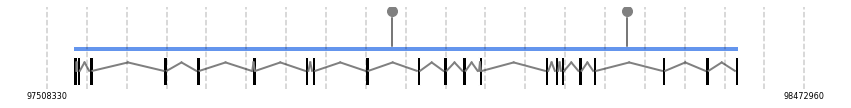

In [2]:
    #exons positions
    exon_pos = [97543299,97544702], [97547885,97548026], [97564044,97564188], [97658624,97658804], [97700407,97700550], [97770814,97770934], [97771732,97771853], [97839116,97839200], [97847948,97848017], [97915614,97915779], [97981281,97981497], [98015115,98015300], [98039315,98039526], [98058773,98058943], [98060614,98060722], [98144650,98144738], [98157272,98157354], [98164906,98165103], [98187065,98187227], [98205947,98206035], [98293669,98293752], [98348819,98348930], [98386439,98386615]
    #marker positions
    marker_pos = [97947885, 98247485]
    gene = GeneImage.GeneImage(exon_pos, marker_pos)
    gene.show()

In [2]:
def build_index(bamfile):
    bam = pysam.AlignmentFile(bamfile, 'rb')
    read_index = pysam.IndexedReads(bam)
    read_index.build()
    return read_index

def get_query_names(bamfile):
    query_names = []
    with pysam.AlignmentFile(bamfile, 'rb') as bam:
        for ali in bam:
            query_names.append(ali.query_name)
    return set(query_names)


In [7]:
def get_TE_hierarchy(consensus_fasta):
    subclass_list = []
    superfamily_list = []
    family_list = []
    with open(consensus_fasta, 'r') as consensus:
        for line in consensus:
            if line.startswith(">"):
                family = line.split("#")[0][1:]
                subclass, superfamily= line.strip().split("#")[1].split("/")
                subclass_list.append(subclass)
                superfamily_list.append(superfamily)
                family_list.append(family)
    hierarchy_df = pd.DataFrame(list(zip(subclass_list, superfamily_list, family_list)), columns =['Subclass', 'Superfamily', 'Family'])
    return hierarchy_df.set_index("Family", inplace=True)
    
HIERARCHY_DF = get_TE_hierarchy(DFAM_TE_ANNOTATION)

In [4]:
# Filter out reads : 

## We filter unmapped, supplementary, and reads with non-optimal AS score.

def filter_max_AS_reads(bamfile, output_bamfile):
    query_names = get_query_names(bamfile)
    read_index = build_index(bamfile)
    with pysam.AlignmentFile(output_bamfile, 'wb', template = pysam.AlignmentFile(bamfile,'rb')) as output:
        for read in query_names:
            ali_list = read_index.find(read)
            max_AS = 0
            primary_and_secondary_alignments = [ali for ali in ali_list if not (ali.is_unmapped or ali.is_supplementary)]
            if primary_and_secondary_alignments :
                max_AS = max([ali.get_tag('AS') for ali in primary_and_secondary_alignments])
                max_AS_alignments = [ali for ali in primary_and_secondary_alignments if ali.get_tag('AS') == max_AS]
                for ali in max_AS_alignments:
                    output.write(ali)
    return output_bamfile


In [5]:
class TransposableElementInsertion:
    def __init__(self, insertion_id, chrom, start, end):
        self.id = insertion_id
        self.chrom = chrom
        self.start = int(start)
        self.end = int(end)
        self.alignments = []
        self.counts = 0
    
    def __repr__(self):
        return self.id
    

In [6]:
class Exon:
    def __init__(self, gene_id, chrom, start, end):
        self.gene_id = gene_id
        self.chrom = chrom
        self.start = start
        self.end = end

In [7]:
def initiate_transposable_element_family_dict(annotations):
    transposable_element_family_dict = {}
    with open(annotations) as annot:
        for line in annot:
            splitted_line = line.strip().split("\t")
            chrom, start, end = [splitted_line[i] for i in [0, 3, 4]]
            ids = splitted_line[-1].split('"')
            family_name = ids[1]
            if int(end) - int(start) > 100:
                new_insertion = TransposableElementInsertion(ids[3], chrom, start, end)
                if family_name not in transposable_element_family_dict:
                    transposable_element_family_dict[family_name] = []
                transposable_element_family_dict[family_name].append(new_insertion)
    return transposable_element_family_dict



In [8]:
def get_subject_coverage(alignment, insertion):
    overlap_start = max(alignment.reference_start, insertion.start)
    overlap_end = min(alignment.reference_end, insertion.end)
    overlap_length = overlap_end - overlap_start
    insertion_length = insertion.end - insertion.start
    subject_coverage = overlap_length / insertion_length
    return subject_coverage

def default_filter(alignment, insertion):
    subject_coverage = get_subject_coverage(alignment, insertion)
    nb_aligned_pairs =  alignment.get_overlap(insertion.start, insertion.end)
    is_ok = (subject_coverage > 0.1 and nb_aligned_pairs > 1)
    return is_ok

def get_exceeding_alignment_length(alignment, insertion):
    overflow_length = 0
    if alignment.reference_start < insertion.start:
        overflow_length += insertion.start -alignment.reference_start
    if alignment.reference_end > insertion.end:
        overflow_length += alignment.reference_end - insertion.end
    return overflow_length

def filter_out_co_expressed(alignment, insertion):
    exceeding_length = get_exceeding_alignment_length(alignment, insertion)
    alignment_length = alignment.reference_end - alignment.reference_start
    is_ok = (exceeding_length < (0.1 * alignment_length))
    return is_ok

def no_filter(alignment, insertion):
    return True

def match_reads_with_insertions(bamfile, family_dict, filter_strategy):
    with pysam.AlignmentFile(bamfile, 'rb') as bam:
        for family, insertion_list in family_dict.items():
            for insertion in insertion_list:
                def apply_filter_strategy(read):
                    return filter_strategy(read, insertion)
                insertion.counts = bam.count(contig=insertion.chrom, start=insertion.start, end=insertion.end, read_callback=apply_filter_strategy)

    return family_dict


In [64]:
def attributing_reads_to_feature(bamfile, family_dict, gene_annotation, filter_strategy):
    def apply_filter_strategy(read):
        return filter_strategy(read, insertion, gene_annotation)
    nb_family = len(family_dict)
    with pysam.AlignmentFile(bamfile, 'rb') as bam:       
        for family, insertion_list in family_dict.items():
            for insertion in insertion_list:
                insertion.counts = bam.count(contig=insertion.chrom, start=insertion.start, end=insertion.end, read_callback=apply_filter_strategy)
    return 0

def parse_gene_annotations(gene_annotations):
    exon_dict = {}
    with open(gene_annotations) as gene_annot:
        for line in gene_annot:
            sline = line.strip().split("\t")
            if "exon" in sline[2]:
                gene_id = sline[8].split('"')[1]
                chrom = sline[0]
                start = int(sline[3])
                end = int(sline[4])
                new_exon = Exon(gene_id, chrom, start, end)
                if chrom not in exon_dict :
                    exon_dict[chrom] = []
                exon_dict[chrom].append(new_exon)
    return exon_dict 

parse_gene_annotations(DMGOTH_GENE_ANNOTATIONS)

def get_overlapped_genes(read, gene_annotations):
    exon_dict = parse_gene_annotations(gene_annotations)
    overlapped_exons = []
    for exon in exon_dict[read.reference_name]:
        if read.reference_end >= exon.start and exon.end >= read.reference_start:
            overlapped_exons.append(exon)
        if read.reference_start > exon.end :
            break
    overlapped_genes = {}
    for exon in overlapped_exons:
        if not exon.gene_id in overlapped_genes:
           overlapped_genes[exon.gene_id] = []
        overlapped_genes[exon.gene_id].append(exon)
    return overlapped_genes


def filter_strategy2(read, insertion, gene_annotations):
    if not filter_out_co_expressed(read, insertion):
        return False
    overlapped_genes = get_overlapped_genes(read, gene_annotations)
    max_nb_of_aligned_pb = read.get_overlap(insertion.start, insertion.end)
    max_aligned_feature = insertion

    for gene, overlapped_exons in overlapped_genes.items():
        nb_of_aligned_pb = 0
        for exon in overlapped_exons:
            nb_of_aligned_pb += read.get_overlap(exon.start, exon.end)
            if nb_of_aligned_pb > max_nb_of_aligned_pb:
                return False
            max_aligned_feature = gene
            max_nb_of_aligned_pb = nb_of_aligned_pb
    return max_aligned_feature == insertion
    # if max_aligned_feature != insertion :
    #     print("Pop")
    #     print(max_aligned_feature)
    #     print(read.query_name, read.reference_name, read.reference_start, read.reference_end)
    #     if not max_aligned_feature == "FBgn0267428":
    #         print(read.query_name, read.reference_name, read.reference_start, read.reference_end)
    #         print(max_aligned_feature)
    #     return False
    # else : 
    #     print("poup")
    #     return True


def get_TE_counting_bis(filtered_bamfile, annotations, gene_annotations, TE_hierarchy_df, filter_strategy):
    family_dict = initiate_transposable_element_family_dict(annotations)
    family_dict = attributing_reads_to_feature(filtered_bamfile, family_dict, gene_annotations, filter_strategy)
    # family_dict, TE_hierarchy_df = merge_family_splitted_between_intern_and_LTR(family_dict, TE_hierarchy_df)
    return (family_dict, TE_hierarchy_df)

new_counting = get_TE_counting_bis(FC30_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, DMGOTH_GENE_ANNOTATIONS, HIERARCHY_DF, filter_strategy2)


poup
poup
poup
poup
poup
poup

poup
poup
poup

poup
poup
poup
poup
poup
poup
poup

poup
poup
poup
poup
poup
poup
poup
poup
poup
poup
poup
poup
poup


KeyboardInterrupt: 

In [7]:
def match_reads_with_insertions_bis(bamfile, family_dict, filter_strategy):
    with pysam.AlignmentFile(bamfile, 'rb') as bam:
        for family, insertion_list in family_dict.items():
            for insertion in insertion_list:
                reads_list = list(bam.fetch(contig=insertion.chrom, start=insertion.start, stop=insertion.end))
                if len(reads_list) > 0:
                    for read in reads_list:
                        features_mapped = get_overlapped_features(read, TE_annotations, gene_annotations)
                        # max_subject_coverage = max([get_subject_coverage(read, feature) for feature in features_mapped])
                        # max_features = [feature ]
                        # attraper toutes les features overlappées par ce read
                        # Calculer le subject coverage pour chacune des features
                        # attribuer la lecture à la feature avec le max subject_coverage
                        # et tant qu'à faire, mean_subject_coverage de la feature s'il s'agit d'un TE

                        print(read.query_name)
                        break
                    break
            break

def get_TE_counting_bis(filtered_bamfile, annotations, TE_hierarchy_df, filter_strategy):
    family_dict = initiate_transposable_element_family_dict(annotations)
    family_dict = match_reads_with_insertions_bis(filtered_bamfile, family_dict, filter_strategy)
    # family_dict, TE_hierarchy_df = merge_family_splitted_between_intern_and_LTR(family_dict, TE_hierarchy_df)
    return (family_dict, TE_hierarchy_df)

# FC30_FAMILY_DICT_bis, HIERARCHY_DF_bis = get_TE_counting_bis(FC30_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, HIERARCHY_DF, filter_out_co_expressed)


In [61]:
def merge_family_splitted_between_intern_and_LTR(family_dict, TE_hierarchy_df):
    bad_suffix_list = ["_I", "-I_DM", "_I_DM", "_LTR", "-LTR_DM", "_LTR_DM"]
    new_family_dict = {}
    new_row_list = []
    for family, insertion_list in family_dict.items() :
        if family in list(TE_hierarchy_df["Family"]):
            new_family_dict[family] = insertion_list
        else:
            family_name_fixed = False
            for bad_suffix in bad_suffix_list:
                if family.endswith(bad_suffix):
                    new_family = family[:-len(bad_suffix)]
                    if not new_family in new_family_dict:
                        new_family_dict[new_family] = insertion_list
                    else :
                        new_family_dict[new_family] += insertion_list
            if family_name_fixed :
                continue
            else:
                new_row_list.append(["Unknown", "Unknown", family])
    TE_hierarchy_df.append(pd.DataFrame(new_row_list,  columns = TE_hierarchy_df.columns))
    return (new_family_dict, TE_hierarchy_df)


In [62]:
def get_TE_counting(filtered_bamfile, annotations, TE_hierarchy_df, filter_strategy):
    family_dict = initiate_transposable_element_family_dict(annotations)
    family_dict = match_reads_with_insertions(filtered_bamfile, family_dict, filter_strategy)
    family_dict, TE_hierarchy_df = merge_family_splitted_between_intern_and_LTR(family_dict, TE_hierarchy_df)
    return (family_dict, TE_hierarchy_df)
# FC30_FAMILY_DICT, HIERARCHY_DF = get_TE_counting(FC30_DMGOTH_MAX_AS_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, HIERARCHY_DF, filter_out_co_expressed)
# FC29_FAMILY_DICT, HIERARCHY_DF = get_TE_counting(FC29_DMGOTH_MAX_AS_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, HIERARCHY_DF, filter_out_co_expressed)

FC30_FAMILY_DICT, HIERARCHY_DF = get_TE_counting(FC30_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, HIERARCHY_DF, filter_out_co_expressed)
FC29_FAMILY_DICT, HIERARCHY_DF = get_TE_counting(FC29_DMGOTH_MAX_AS_PRIMARY_ONLY_BAMFILE, REPEATMASKER_TE_ANNOTATIONS, HIERARCHY_DF, filter_out_co_expressed)

In [63]:
def from_counting_to_df(counting_dict):
    family_list = []
    min_TE_length_list = []
    max_TE_length_list = []
    counting_list = []
    nb_expressed_insertion_list = []
    nb_insertion_list = []
    most_expressed_insertion_list = []
    for family, insertion_list in counting_dict.items():
        family_list.append(family)
        nb_insertion_list.append(len(insertion_list))
        nb_expressed_insertion = 0
        min_TE_length = 9999999999
        max_TE_length = 0
        family_counts = 0
        most_expressed_insertion = None
        max_count = 0
        for insertion in insertion_list :
            insertion_length = insertion.end - insertion.start
            min_TE_length = min(min_TE_length, insertion_length)
            max_TE_length = max(max_TE_length, insertion_length)
            family_counts += insertion.counts
            max_count = max(max_count,insertion.counts)
            if insertion.counts >= max_count :
                most_expressed_insertion = insertion.id
            if insertion.counts > 0 :
                nb_expressed_insertion += 1
        nb_expressed_insertion_list.append(nb_expressed_insertion)
        min_TE_length_list.append(min_TE_length)
        max_TE_length_list.append(max_TE_length)
        counting_list.append(family_counts)
        most_expressed_insertion_list.append(most_expressed_insertion)
        
    counting_df = pd.DataFrame(list(zip(family_list, min_TE_length_list, max_TE_length_list, counting_list, nb_insertion_list, nb_expressed_insertion_list, most_expressed_insertion_list)), columns=["Family", "Min_TE_length","Max_TE_length", "Counts", "nb_of_insertion", "nb_of_expressed_insertion", "Most_expressed_insertion"])
    return counting_df


In [64]:
FC30_DMGOTH_COUNTING_DF = from_counting_to_df(FC30_FAMILY_DICT)
FC29_DMGOTH_COUNTING_DF = from_counting_to_df(FC29_FAMILY_DICT)

In [65]:
FC30_DMGOTH_COUNTING_DF.to_csv('FC30_DMGOTH_COUNTING_DF.filter_no_co-expressed.tsv', sep = '\t', index=False)
FC29_DMGOTH_COUNTING_DF.to_csv('FC29_DMGOTH_COUNTING_DF.filter_no_co-expressed.tsv', sep = '\t', index=False)

In [66]:
# def add_hierarchy_to_counting_df(counting_df, hierarchy_df):
#     new_df = hierarchy_df.merge(counting_df, on='Family')
#     return new_df
# new_df = add_hierarchy_to_counting_df(FC29_DMGOTH_COUNTING_DF, HIERARCHY_DF)
# new_df.head()

In [67]:
def create_table_from_counting(female_counting, male_counting, hierarchy):
    male_counting = male_counting.drop(columns=["Min_TE_length", "Max_TE_length", "nb_of_insertion"])
    TE_data_table = hierarchy.merge(female_counting, on='Family').merge(male_counting, on='Family')
    TE_data_table.columns = ["Subclass", "Superfamily", "Family", "Min_TE_length", "Max_TE_length", "Female_Counts", "Nb_of_insertion", "Female_nb_of_expressed_insertion", "Female_most_expressed_insertion", "Male_Counts", "Male_nb_of_expressed_insertion", "Male_most_expressed_insertion"]
    TE_data_table = TE_data_table[["Subclass", "Superfamily", "Family", "Nb_of_insertion", "Min_TE_length", "Max_TE_length", "Female_Counts", "Female_nb_of_expressed_insertion", "Female_most_expressed_insertion", "Male_Counts", "Male_nb_of_expressed_insertion", "Male_most_expressed_insertion"]]
    return TE_data_table

TE_data_table = create_table_from_counting(FC30_DMGOTH_COUNTING_DF, FC29_DMGOTH_COUNTING_DF, HIERARCHY_DF)



In [68]:
TE_data_table.sort_values(by="Male_Counts", axis=0,  ascending=False).head(10)
TE_data_table.to_csv('TE_data_table.tsv', sep = '\t', index=False)

In [3]:
TE_data_table = pd.read_csv('TE_data_table.tsv', sep = '\t')

In [69]:
def write_insertion_table(male_family_dict, female_family_dict, outputfile):
    with open(outputfile, 'w') as output:
        output.write("insertion_id\tfemale_count\tmale_count\n")
        for family_name in male_family_dict.keys():
            male_insertion_list = male_family_dict[family_name]
            female_insertion_list = female_family_dict[family_name]
            for index, insertion in enumerate(male_insertion_list):

                insertion_id = male_insertion_list[index].id
                male_count = male_insertion_list[index].counts
                female_count = female_insertion_list[index].counts
                if male_count > 0 or female_count > 0 :
                    output.write("\t".join([insertion.id, str(female_count), str(male_count)]) + "\n")

write_insertion_table(FC29_FAMILY_DICT, FC30_FAMILY_DICT, INSERTION_TABLE)

In [5]:
def plot_TE_expression_profile_by_family(TE_data_table):

    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

    fig.add_trace(
        go.Pie(labels=TE_data_table["Superfamily"], values=TE_data_table["Female_Counts"], textinfo='value', name = "Female"),
        1, 1)

    fig.add_trace(
        go.Pie(labels=TE_data_table["Superfamily"], values=TE_data_table["Male_Counts"], textinfo='value', name = "Male"),
        1, 2)
    fig.update_traces(hole=.4, hoverinfo="label+value")

    fig.update_layout(
        title_text= "Superfamily expression profile",
        width=1200,
        height=500,
        # Add annotations in the center of the donut pies.
        annotations=[dict(text='Female', x=0.19, y=0.5, font_size=20, showarrow=False),
                    dict(text='Male', x=0.80, y=0.5, font_size=20, showarrow=False)])
    fig.show()

In [6]:
def plot_TE_expression_profile_by_superfamily(TE_data_table):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

    fig.add_trace(
        go.Pie(labels=TE_data_table["Subclass"], values=TE_data_table["Female_Counts"], textinfo='value', name = "Female"),
        1, 1)

    fig.add_trace(
        go.Pie(labels=TE_data_table["Subclass"], values=TE_data_table["Male_Counts"], textinfo='value', name = "Male"),
        1, 2)
    fig.update_traces(hole=.4, hoverinfo="label+value")

    fig.update_layout(
        title_text= "Subclass expression profile",
        width=1200,
        height=500,
        # Add annotations in the center of the donut pies.
        annotations=[dict(text='Female', x=0.19, y=0.5, font_size=20, showarrow=False),
                    dict(text='Male', x=0.80, y=0.5, font_size=20, showarrow=False)])
    fig.show()

In [7]:
plot_TE_expression_profile_by_family(TE_data_table)

In [8]:
plot_TE_expression_profile_by_superfamily(TE_data_table)

In [74]:
TE_data_table.head(10)

,Subclass,Superfamily,Family,Nb_of_insertion,Min_TE_length,Max_TE_length,Female_Counts,Female_nb_of_expressed_insertion,Female_most_expressed_insertion,Male_Counts,Male_nb_of_expressed_insertion,Male_most_expressed_insertion
0,LINE,R1-LOA,Baggins1,137,121,10648,2,2,Baggins1_3L_RaGOO_24293575_24300805,13,5,Baggins1_2R_RaGOO_2570496_2580847
1,DNA,TcMar-Tc1,BARI1,9,114,1563,0,0,BARI1_X_RaGOO_21428317_21429694,5,1,BARI1_2L_RaGOO_21112657_21113769
2,DNA,TcMar-Tc1,BARI_DM,16,1232,1732,1,1,BARI_DM_2R_RaGOO_42130_43850,0,0,BARI_DM_3R_RaGOO_18377955_18379687
3,LINE,I-Jockey,BS,66,101,7501,2,2,BS_3L_RaGOO_25670374_25671727,3,3,BS_3L_RaGOO_26196418_26197513
4,LINE,I-Jockey,BS2,117,120,9056,1,1,BS2_2R_RaGOO_2406301_2407991,10,4,BS2_2R_RaGOO_3748515_3753218
5,LINE,I-Jockey,BS3_DM,52,114,2183,0,0,BS3_DM_X_RaGOO_21935688_21936234,9,3,BS3_DM_3R_RaGOO_1150409_1151578
6,LINE,I-Jockey,BS4_DM,3,103,750,0,0,BS4_DM_3R_RaGOO_4052534_4053284,1,1,BS4_DM_3R_RaGOO_4052534_4053284
7,LTR,Gypsy,CIRCE,36,123,7880,0,0,CIRCE_X_RaGOO_22014034_22017447,31,6,CIRCE_3R_RaGOO_3073861_3079193
8,LTR,Gypsy,DM412,60,111,7034,8,4,DM412_3R_RaGOO_3388391_3389451,14,10,DM412_2R_RaGOO_2546519_2550576
9,LTR,Gypsy,DM412B_LTR,20,107,8866,1,1,DM412B_LTR_3R_RaGOO_21307972_21315446,5,3,DM412B_LTR_X_RaGOO_11799809_11807235


In [75]:
df = TE_data_table.copy()
expressed = df["Female_Counts"] > 0
df = df[expressed]
# fig = px.sunburst(df, path=['SubClass', 'SuperFamily', 'Family'], values='Male_Counts', color = "Male_subject_coverage")
fig = px.sunburst(df, path=['Subclass', 'Superfamily', 'Family'], values='Female_Counts')
fig.show()

In [76]:
df = TE_data_table.copy()
expressed = df["Male_Counts"] > 0
df = df[expressed]
# fig = px.sunburst(df, path=['SubClass', 'SuperFamily', 'Family'], values='Male_Counts', color = "Male_subject_coverage")
fig = px.sunburst(df, path=['Subclass', 'Superfamily', 'Family'], values='Male_Counts')
fig.show()